In [60]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Looking at real data of malaria parasitized cells vs uninfected from NIH library site.
# Training a CNN to preidct malarial activity

In [2]:
dir = '/Users/kieranodonnell/Desktop/Codes/Data/cell_images'

In [3]:
os.listdir(dir)

['test', 'train']

In [5]:
test_dir = dir+'/test/'
train_dir = dir+'/train/'

In [7]:
train_dir

'/Users/kieranodonnell/Desktop/Codes/Data/cell_images/train/'

In [8]:
os.listdir(test_dir)

['parasitized', 'uninfected']

In [9]:
# Lables are parasitized and unifected

In [27]:
# Looking at single image
os.listdir(train_dir+'parasitized')[404]

'C39P4thinF_original_IMG_20150622_105102_cell_103.png'

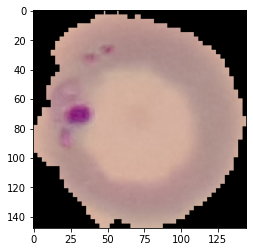

In [28]:
infected_cell = train_dir+'parasitized/'+'C39P4thinF_original_IMG_20150622_105102_cell_103.png'
plt.imshow(imread(infected_cell))

In [30]:
# Can see smudge showing infection
imread(infected_cell).shape

(148, 145, 3)

In [33]:
# Looking as single image
os.listdir(train_dir+'uninfected')[44]

'C164P125ThinF_IMG_20151116_113954_cell_58.png'

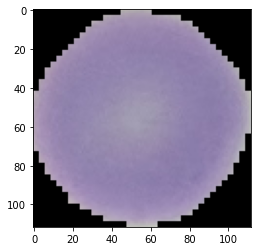

In [34]:
uninfected_cell = train_dir+'uninfected/'+'C164P125ThinF_IMG_20151116_113954_cell_58.png'
plt.imshow(imread(uninfected_cell))

In [36]:
# Cannot see smudge showing infection
imread(uninfected_cell).shape

(112, 112, 3)

In [37]:
# Finding numbers
len(os.listdir(train_dir+'uninfected'))

12480

In [38]:
len(os.listdir(train_dir+'parasitized'))

12480

In [39]:
len(os.listdir(test_dir+'parasitized'))

1300

In [40]:
len(os.listdir(test_dir+'uninfected'))

1300

In [42]:
# All images are a different size!
x_dim = []
y_dim = []

for image_file in os.listdir(test_dir+'uninfected'):
    img = imread(test_dir+'uninfected/'+image_file)
    x_dims, y_dims, colours = img.shape
    x_dim.append(x_dims)
    y_dim.append(y_dims)

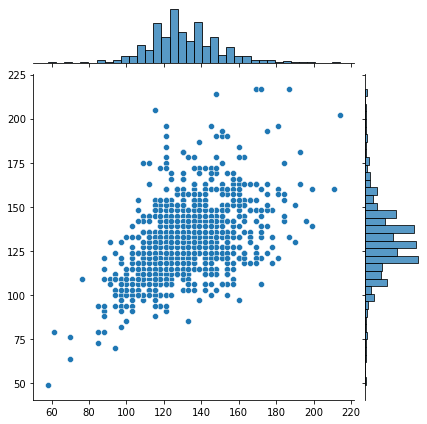

In [47]:
# Looking at historgame of image dimensions
sns.jointplot(x=x_dim, y = y_dim)

In [56]:
# Resize all images to make them same size. Will choose average size whhc is around 131x131
print(np.mean(x_dim), np.mean(y_dim))


130.92538461538462 130.75


In [57]:
image_shape = (131,131,3)

In [62]:
# Data processing - this model will have batch processing -> images are pretty large. Will also add random rotations etc

img_data_gen = ImageDataGenerator(rotation_range = 45,
                                 width_shift_range=0.25,
                                 height_shift_range=0.25,
                                 rescale = 1,
                                 shear_range=0.25,
                                 zoom_range=0.25,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode='nearest',)

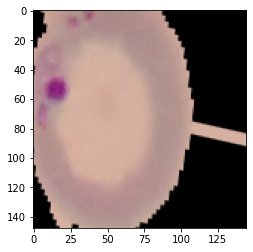

In [68]:
# Showing what a random_transform of an image looks like -> adds more data to dataset
parasitic = imread(infected_cell)
plt.imshow(img_data_gen.random_transform(parasitic))


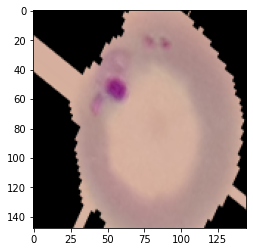

In [69]:
plt.imshow(img_data_gen.random_transform(parasitic))

In [70]:
# Data flow in batches -> files are already in correct format (sub directories)

img_data_gen.flow_from_directory(train_dir)

Found 24958 images belonging to 2 classes.


In [71]:
img_data_gen.flow_from_directory(test_dir)

Found 2600 images belonging to 2 classes.


In [80]:
# Model definition

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3,3), input_shape = image_shape, activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = image_shape, activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = image_shape, activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.45))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 129, 129, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 62, 62, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

In [77]:
timestamp = datetime.now().strftime("%d/%m/%Y, %H:%M:%S")

In [78]:
# Define TBoard and directory

log_directory = 'logs/fit'
log_directory = log_directory+'/'+timestamp

board = TensorBoard(log_dir = log_directory,
                   histogram_freq = 1,
                   write_graph = True,
                   write_images = True,
                   update_freq = 'epoch',
                   profile_batch = 2,
                   embeddings_freq = 1)

In [79]:
earlystop_callback = EarlyStopping(monitor='val_loss', patience=2, mode = 'min')

In [85]:
batch_size = 32
training_image_gen = img_data_gen.flow_from_directory(train_dir, target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size = batch_size,
                                                     class_mode='binary')

test_image_gen = img_data_gen.flow_from_directory(test_dir, target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size = batch_size,
                                                     class_mode='binary',
                                                     shuffle=False)

training_image_gen.class_indices

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


{'parasitized': 0, 'uninfected': 1}

In [87]:
# Final model
final_model = model.fit_generator(training_image_gen,
              epochs=50,
              validation_data=test_image_gen, 
              callbacks=[earlystop_callback,board],
              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
  1/780 [..............................] - ETA: 0s - loss: 12.0694 - accuracy: 0.5938WARNING:tensorflow:From /Users/kieranodonnell/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
780/780 [==============================] - 757s 971ms/step - loss: 1.1521 - accuracy: 0.5173 - val_loss: 0.6877 - val_accuracy: 0.5465
Epoch 2/50
780/780 [==============================] - 610s 782ms/step - loss: 0.6900 - accuracy: 0.5415 - val_loss: 0.6859 - val_accuracy: 0.5596
Epoch 3/50
780/780 [==============================] - 823s 1s/step - loss: 0.6856 - accuracy: 0.5589 - val_loss: 0.6847 - val_accuracy: 0.5585
Epoch 4/50
780/780 [==============================] - 910s 1s/step - loss: 0.4305 - accuracy: 0.8086 

In [105]:
# Saving model

from tensorflow.keras.models import load_model
model.save('malarial_cells_model.h5')

In [ ]:
# Evaluating model

In [89]:
history_loss = pd.DataFrame(model.history.history)

<AxesSubplot:>

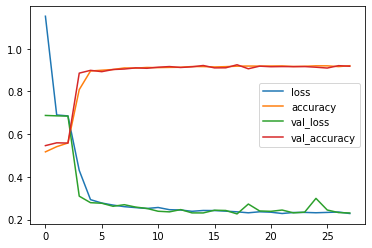

In [90]:
history_loss.plot()

In [99]:
model.evaluate_generator(test_image_gen)

[0.2245492786169052, 0.9200000166893005]

In [93]:
model.metrics_names

['loss', 'accuracy']

In [94]:
# Around 92% accuracy!

In [109]:
preds = model.predict(test_image_gen)

In [110]:
# Getting predictions with over 50% sureness
# If over 50%, label as true -> uninfected
# Can increase this value - i.e only 90% sure 
predictions = preds > 0.5

In [111]:
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [112]:
from sklearn.metrics import classification_report, confusion_matrix

In [113]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92      1300
           1       0.90      0.95      0.93      1300

    accuracy                           0.92      2600
   macro avg       0.92      0.92      0.92      2600
weighted avg       0.92      0.92      0.92      2600



In [114]:
print(confusion_matrix(test_image_gen.classes,predictions))

[[1168  132]
 [  66 1234]]


In [169]:
# Predict on a single image

from tensorflow.keras.preprocessing import image

In [187]:
# Looking at single image
os.listdir(train_dir+'parasitized')[101]

'C181P142ThinF_IMG_20151127_160434_cell_159.png'

In [188]:
infected_cell = train_dir+'parasitized/'+'C181P142ThinF_IMG_20151127_160434_cell_159.png'

In [189]:
# Choosing an image we know to be infected
new_image = image.load_img(infected_cell,target_size = image_shape)

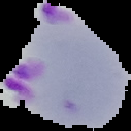

In [190]:
new_image

In [191]:
img_array = image.img_to_array(new_image)

In [192]:
img_array.shape

(131, 131, 3)

In [193]:
img_array = np.expand_dims(img_array,axis =0)

In [194]:
img_array.shape

(1, 131, 131, 3)

In [196]:
# Predict

model.predict(img_array)

array([[0.0006732]], dtype=float32)

In [198]:
training_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [200]:
# So its correct guessing!

In [202]:
#pwd

In [ ]:
# looking at tensorboard -> https://localhost:6006/
# print(log_directory)
# pwd
# tensorboard --logdir logs/fit